# Homework 3 - CLV

### Steps

1. Load packages and data
2. Separate numeric and object vars
3. Drop var=0 numeric and unique value=1 object vars
4. For numerics:
  - Plot corr between two features >= 0.75
  - Detect outliers (print number)
  - Normalize with Max()
5. For objects:
  - separate unique values = 2 and > 2
  - for = 2 encode into categories and join to numeric
  - for > 3 observe to get dummies, encode categories or transform
  - for datetime object, get Min() date, normalize rest as Days wrt Min()
  - scale the data with Max()
6. Set up models with a bit different than default params (yet not fully tuned)
7. Fit all 4 model, predict both for train and test (both for scaled and unscaled)
8. Calculate MSE, RMSE and R^2 for all model (train and test, scaled unscaled)
9. Winner: as for now, RF (or GB, if a bit of overfitting neglected)
10. Next (for potentially better accuracy):
  - Drop outliers
  - Tune hyperparameters (clearly models overfit)
  - Test results with CV
  - Continue feature engineering (merge more values, transform data etc.)
  - Get important features (coef attribute) in linear regression and eliminate one at a time (linear model will be improved)

In [0]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# to avoid calling plt.show() everytime
%matplotlib inline

In [0]:
#reading data from GitHub repo
raw_data = pd.read_csv("https://github.com/HrantDavtyan/Business_Analytics/blob/master/CLV.csv?raw=true")

In [4]:
# print info and present first 3 rows
print(raw_data.info())
raw_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer                         9134 non-null object
State                            9134 non-null object
Customer Lifetime Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception    9134 non-null int64
Number of Open Complaints        9134 non-null int64
Number of Policies               

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize


### Separating numerics and objects

In [5]:
#separate numeric and object variables
data_numeric = raw_data.select_dtypes(exclude="object")
data_object = raw_data.select_dtypes(include="object")

#choose numeric vars with non-zero variance
print("Numeric")
print("Before: ",len(data_numeric.columns))
data_numeric = data_numeric.loc[:,data_numeric.var()!=0]
print("After: ",len(data_numeric.columns))

print("\n") #break line in output

#choose object vars with more than 1 unique value
print("Objects")
print("Before: ",len(data_object.columns))
data_object = data_object.loc[:,[len(data_object[i].unique())>1 for i in data_object.columns]]
print("After: ",len(data_object.columns))

#choose object vars with only 2 values, encode and join back to numerics
data_encode = data_object.loc[:,[len(data_object[i].unique())==2 for i in data_object.columns]]
data_encode = data_encode.apply(LabelEncoder().fit_transform)
data_numeric = data_numeric.join(data_encode)

#choose object vars with more than 2 values and observe
data_dummy = data_object.loc[:,[len(data_object[i].unique())>2 for i in data_object.columns]]

Numeric
Before:  8
After:  8


Objects
Before:  16
After:  16


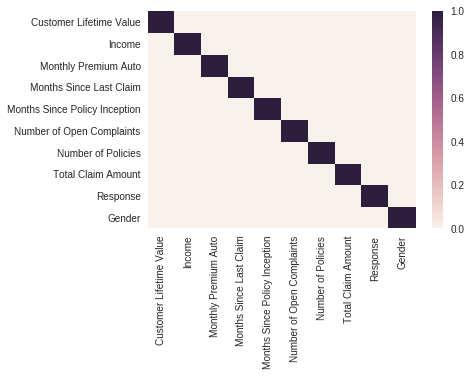

In [6]:
#no change happened
#plot correlation heatmap to see any correlations above or equal to 75% in absolute values
#we will see that no group of vars satisfy the condition, i.e. no high correlation
sns.heatmap(data_numeric.corr().abs()>=0.75)

### Outliers and Normalization

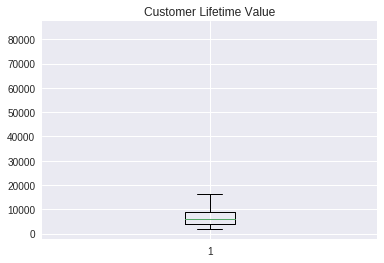

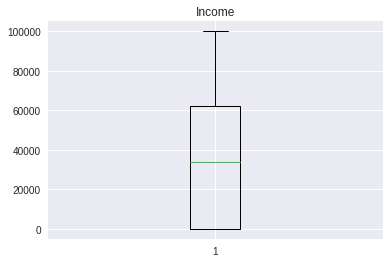

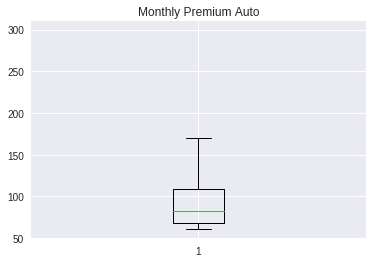

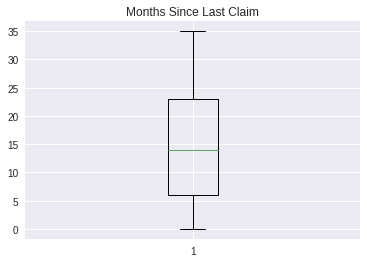

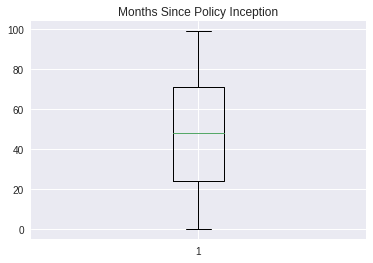

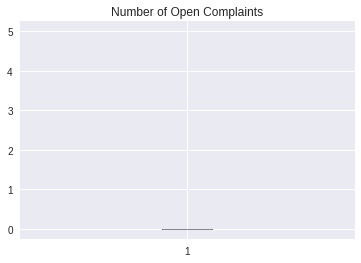

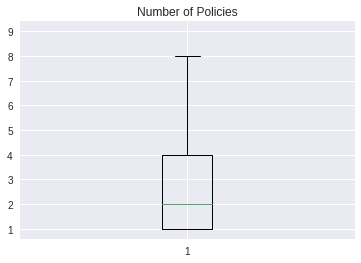

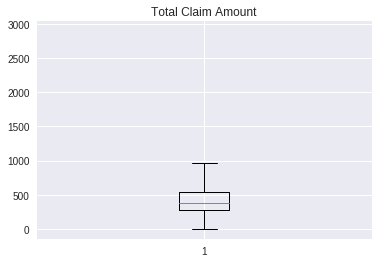

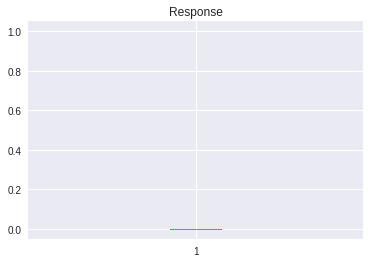

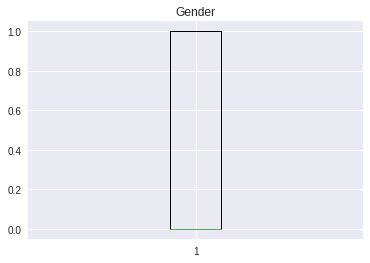

In [7]:
#observe outliers first visually then using iQR
for i in data_numeric.columns:
  plt.boxplot(data_numeric[i])
  plt.title(i)
  plt.show()

In [10]:
#create function for IQR with 2 arguments: varaible and coef (default=1.5)

def IQR(variable,coef=1.5):
  Q3 = np.percentile(variable,75)
  Q2 = np.percentile(variable,50)
  Q1 = np.percentile(variable,25)
  IQR = Q3 - Q1
  lower = Q1 - coef*IQR
  upper = Q3 + coef*IQR
  return [lower, upper]

#use that function to calculate number of outliers in each var
#i.e. length of data after choosing observations out of of the IQR range
#for the sake of simplicity, we will not drop them
#you are encouraged to drop and observe the effect

#note, to be strict towards outliers, coef is set to 3
for i in data_numeric.columns:
  my_box = IQR(data_numeric[i],3)
  out_num = len(data_numeric[i][~data_numeric[i].between(my_box[0],my_box[1])])
  print(i,"has",out_num,"outliers")

Customer Lifetime Value has 367 outliers
Income has 0 outliers
Monthly Premium Auto has 86 outliers
Months Since Last Claim has 0 outliers
Months Since Policy Inception has 0 outliers
Number of Open Complaints has 1882 outliers
Number of Policies has 0 outliers
Total Claim Amount has 115 outliers
Response has 1308 outliers
Gender has 0 outliers


In [0]:
#create a function to normalize the data
def my_scaler(col):
  return (col - np.min(col))/np.max(col)

#apply that function to each column of the dataframe
data_scaled = data_numeric.apply(my_scaler)

### Transformations of "objects"

In [12]:
data_dummy.head(3)

,Customer,State,Coverage,Education,Effective To Date,EmploymentStatus,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,BU79786,Washington,Basic,Bachelor,2/24/11,Employed,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,QZ44356,Arizona,Extended,Bachelor,1/31/11,Unemployed,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,AI49188,Nevada,Premium,Bachelor,2/19/11,Employed,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize


In [14]:
#drop columns that are assumed to have no contribution to CLV
data_dummy = data_dummy.drop(["Customer"],axis=1)

#for the rest print unqiue values to understand possible future steps
for i in data_dummy.columns:
  print(i,":",data_dummy[i].unique())

State : ['Washington' 'Arizona' 'Nevada' 'California' 'Oregon']
Coverage : ['Basic' 'Extended' 'Premium']
Education : ['Bachelor' 'College' 'Master' 'High School or Below' 'Doctor']
Effective To Date : ['2/24/11' '1/31/11' '2/19/11' '1/20/11' '2/3/11' '1/25/11' '1/18/11'
 '1/26/11' '2/17/11' '2/21/11' '1/6/11' '2/6/11' '1/10/11' '1/17/11'
 '1/5/11' '2/27/11' '1/14/11' '1/21/11' '2/5/11' '1/29/11' '2/28/11'
 '2/12/11' '2/2/11' '2/7/11' '1/22/11' '2/13/11' '1/15/11' '1/8/11'
 '1/11/11' '1/28/11' '2/8/11' '2/23/11' '1/2/11' '2/16/11' '1/27/11'
 '1/23/11' '1/9/11' '2/11/11' '2/4/11' '2/1/11' '2/15/11' '2/26/11'
 '1/16/11' '1/1/11' '2/10/11' '1/24/11' '2/25/11' '1/12/11' '2/9/11'
 '1/19/11' '1/4/11' '2/14/11' '2/20/11' '2/18/11' '1/3/11' '1/13/11'
 '1/30/11' '2/22/11' '1/7/11']
EmploymentStatus : ['Employed' 'Unemployed' 'Medical Leave' 'Disabled' 'Retired']
Location Code : ['Suburban' 'Rural' 'Urban']
Marital Status : ['Married' 'Single' 'Divorced']
Policy Type : ['Corporate Auto' 'Persona

In [0]:
#define function for encoding categoricals with intrinsic orderd
def my_encoder(data,column_name,order_list):
  encoded_values = data[column_name].astype("category").cat.reorder_categories(order_list).cat.codes
  return encoded_values

In [0]:
data_dummy["Vehicle Size"] = my_encoder(data_dummy,"Vehicle Size",['Small','Medsize','Large'])
data_dummy["Coverage"] = my_encoder(data_dummy,"Coverage",['Basic', 'Extended', 'Premium'])
data_dummy["Education"] = my_encoder(data_dummy,"Education",['High School or Below','College','Bachelor','Master','Doctor'])

In [0]:
#convert "effective to date" column into datetime format
#choose closest date among
#use it as base and compare all other dates (substract min) with it
#result: Days_effective column
data_dummy["Days_effective"] = pd.to_datetime(data_dummy["Effective To Date"])-pd.to_datetime(data_dummy["Effective To Date"]).min()

#covert this new column to provide only days as integer (not as datatime)
data_dummy.Days_effective = data_dummy.Days_effective.dt.days

#drop the row datetime column
data_dummy = data_dummy.drop(["Effective To Date"],axis=1)

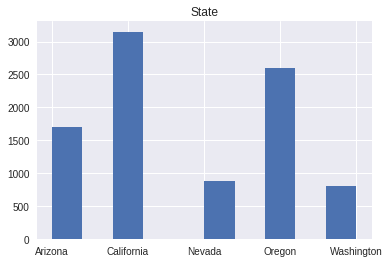

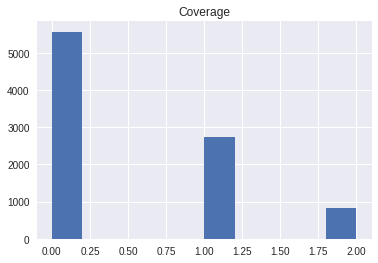

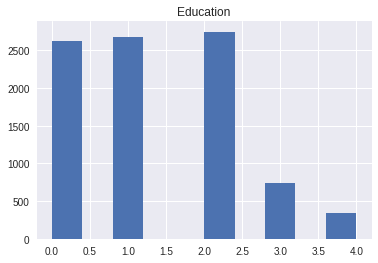

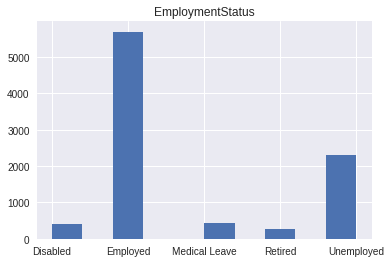

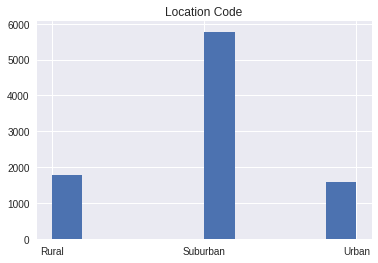

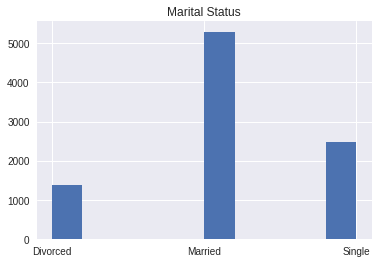

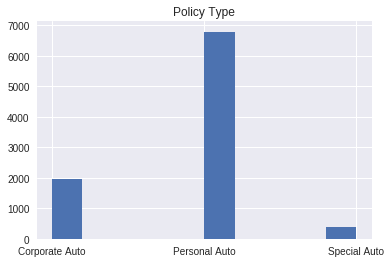

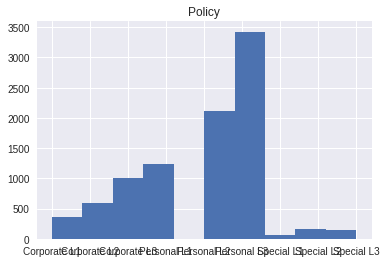

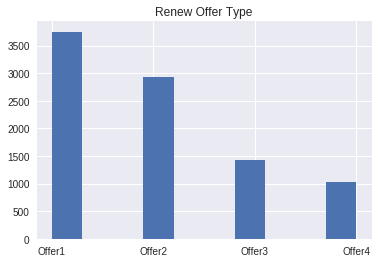

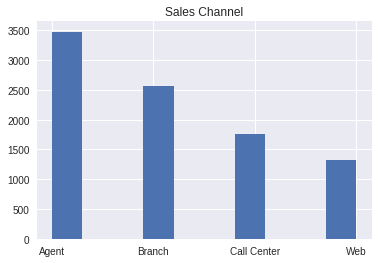

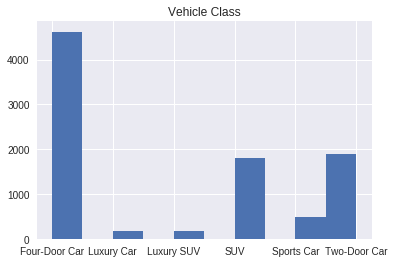

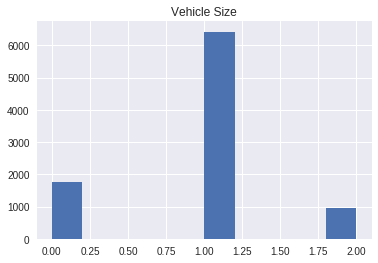

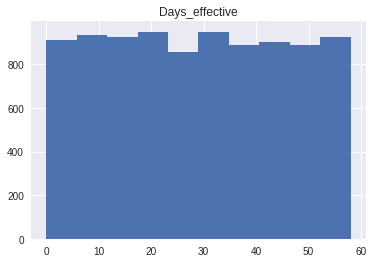

In [18]:
#plot hist for untouched variables to see appropriate transformations
#(we will plot all in this dataframe, but take a look at only untouched)
for i in data_dummy.columns:
  plt.hist(data_dummy[i])
  plt.title(i)
  plt.show()

In [0]:
#as we can see some categoricals have a value that covers more than 50% of observations
#for simplicity we will create a var with value 1 for that value and 0 for rest
#rest will be converted into dummies

#"mergers"
data_dummy.EmploymentStatus = np.where(data_dummy.EmploymentStatus=="Employed",1,0)
data_dummy["Location Code"] = np.where(data_dummy["Location Code"]=="Suburban",1,0)
data_dummy["Marital Status"] = np.where(data_dummy["Marital Status"]=="Married",1,0)
data_dummy["Policy Type"] = np.where(data_dummy["Policy Type"]=="Personal Auto",1,0)
data_dummy["Vehicle Class"] = np.where(data_dummy["Vehicle Class"]=="Four-Door Car",1,0)

#dummies
data_dummy = data_dummy.join(pd.get_dummies(data_dummy.State,prefix="State",drop_first=True))
data_dummy = data_dummy.join(pd.get_dummies(data_dummy.Policy,prefix="Policy",drop_first=True))
data_dummy = data_dummy.join(pd.get_dummies(data_dummy["Renew Offer Type"],prefix="Offer",drop_first=True))
data_dummy = data_dummy.join(pd.get_dummies(data_dummy["Sales Channel"],prefix="Sales",drop_first=True))

data_dummy = data_dummy.drop(["State","Policy","Renew Offer Type","Sales Channel"],axis=1)

#join results to numeric and save into new dataframe called "data"
data = data_numeric.join(data_dummy)

In [0]:
#scale data_dummy dataframe as well (there ar enot only dummies actually,for example, we have days as well)
data_dummy_scaled = data_dummy.apply(my_scaler)

#join it with scaled numeric and save into new dataframe called "DATA"
DATA = data_scaled.join(data_dummy_scaled)

#afterwards, UPPERCASE is for scaled, lowercase is for unscaled data

### Modeling

In [0]:
#unscaled
y = data["Customer Lifetime Value"]
x = data.drop("Customer Lifetime Value",axis=1)

#scaled
Y = DATA["Customer Lifetime Value"]
X = DATA.drop("Customer Lifetime Value",axis=1)

In [0]:
#for similpicity, we will set up a bit tuned models instead of dafeault
model_tree = DecisionTreeRegressor(max_depth=5,random_state=42)
model_linear = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100,max_depth=5,random_state=42)
model_gb = GradientBoostingRegressor(random_state=42)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

In [26]:
#unscaled
#fit all 4 models, make prediction and compare it to true values (using MSE)
#rake sqrt(MSE) to get RMSE, round up both to 2 decimals, print
model_tree.fit(x_train,y_train)
model_linear.fit(x_train,y_train)
model_rf.fit(x_train,y_train)
model_gb.fit(x_train,y_train)

#train
tree_p_0 = model_tree.predict(x_train)
line_p_0 = model_linear.predict(x_train)
rf_p_0 = model_rf.predict(x_train)
gb_p_0 = model_gb.predict(x_train)

#test
tree_p = model_tree.predict(x_test)
line_p = model_linear.predict(x_test)
rf_p = model_rf.predict(x_test)
gb_p = model_gb.predict(x_test)

print("Train")
for i in [tree_p_0,line_p_0,rf_p_0,gb_p_0]:
  print("RMSE:",np.round(np.sqrt(mean_squared_error(y_train,i)),decimals=2))
  print("MSE",np.round(mean_squared_error(y_train,i),decimals=2))
  print("\n")


print("Test")
for i in [tree_p,line_p,rf_p,gb_p]:
  print("RMSE:",np.round(np.sqrt(mean_squared_error(y_test,i)),decimals=2))
  print("MSE",np.round(mean_squared_error(y_test,i),decimals=2))
  print("\n")
  
  
#print also R2 for train and test components
print("Train")

print(np.round(model_tree.score(x_train,y_train)*100,decimals=2))
print(np.round(model_linear.score(x_train,y_train)*100,decimals=2))
print(np.round(model_rf.score(x_train,y_train)*100,decimals=2))
print(np.round(model_gb.score(x_train,y_train)*100,decimals=2))

print("\n")
print("Test")

print(np.round(model_tree.score(x_test,y_test)*100,decimals=2))
print(np.round(model_linear.score(x_test,y_test)*100,decimals=2))
print(np.round(model_rf.score(x_test,y_test)*100,decimals=2))
print(np.round(model_gb.score(x_test,y_test)*100,decimals=2))

Train
RMSE: 3720.73
MSE 13843859.25


RMSE: 6182.66
MSE 38225268.73


RMSE: 3643.39
MSE 13274279.83


RMSE: 3485.05
MSE 12145591.41


Test
RMSE: 4227.85
MSE 17874675.32


RMSE: 6530.85
MSE 42652048.96


RMSE: 4089.25
MSE 16721929.84


RMSE: 4088.33
MSE 16714467.04


Train
70.03
17.26
71.27
73.71


Test
64.41
15.08
66.71
66.72


Results show that according to Test MSE GB and RF (and GB among them) are the best. In terms of variance between train and test results (overfitting), Linear model is winning, yet it is pretty inaccurate. Among GB and RF, RF has less overfitting as expected. We may apply the same approach for scaled data.

In [28]:
#unscaled
#fit all 4 models, make prediction and compare it to true values (using MSE)
#rake sqrt(MSE) to get RMSE, round up both to 5 decimals, print
model_tree.fit(X_train,Y_train)
model_linear.fit(X_train,Y_train)
model_rf.fit(X_train,Y_train)
model_gb.fit(X_train,Y_train)

#train
tree_p_0 = model_tree.predict(X_train)
line_p_0 = model_linear.predict(X_train)
rf_p_0 = model_rf.predict(X_train)
gb_p_0 = model_gb.predict(X_train)

#test
tree_p = model_tree.predict(X_test)
line_p = model_linear.predict(X_test)
rf_p = model_rf.predict(X_test)
gb_p = model_gb.predict(X_test)

print("Train")
for i in [tree_p_0,line_p_0,rf_p_0,gb_p_0]:
  print("RMSE:",np.round(np.sqrt(mean_squared_error(Y_train,i)),decimals=5))
  print("MSE",np.round(mean_squared_error(Y_train,i),decimals=5))
  print("\n")


print("Test")
for i in [tree_p,line_p,rf_p,gb_p]:
  print("RMSE:",np.round(np.sqrt(mean_squared_error(Y_test,i)),decimals=5))
  print("MSE",np.round(mean_squared_error(Y_test,i),decimals=5))
  print("\n")
  
  
#print also R2 for train and test components
print("Train")

print(np.round(model_tree.score(X_train,Y_train)*100,decimals=5))
print(np.round(model_linear.score(X_train,Y_train)*100,decimals=5))
print(np.round(model_rf.score(X_train,Y_train)*100,decimals=5))
print(np.round(model_gb.score(X_train,Y_train)*100,decimals=5))

print("\n")
print("Test")

print(np.round(model_tree.score(X_test,Y_test)*100,decimals=5))
print(np.round(model_linear.score(X_test,Y_test)*100,decimals=5))
print(np.round(model_rf.score(X_test,Y_test)*100,decimals=5))
print(np.round(model_gb.score(X_test,Y_test)*100,decimals=5))

Train
RMSE: 0.04465
MSE 0.00199


RMSE: 0.07425
MSE 0.00551


RMSE: 0.04373
MSE 0.00191


RMSE: 0.04182
MSE 0.00175


Test
RMSE: 0.05074
MSE 0.00257


RMSE: 0.07834
MSE 0.00614


RMSE: 0.04908
MSE 0.00241


RMSE: 0.04906
MSE 0.00241


Train
70.0329
17.13261
71.26525
73.70905


Test
64.41244
15.16027
66.69783
66.72236


As expected tree based models did not experience any improvement, yet the inaccrate linear model became less inaccurate.